In [112]:
import argparse
from tqdm import tqdm
from math import ceil

import torch
import torch.nn.functional as F
from torch_geometric.data import DenseDataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch.utils.data import random_split

from utils.data_loader import *
from utils.eval_helper import *
import matplotlib.pyplot as plt

Paper: Graph Neural Networks with Continual Learning for Fake News Detection from Social Media
Link: https://arxiv.org/pdf/2007.03316.pdf

In [113]:
seed= torch.manual_seed(42)
dataset = 'politifact'
batch_size = 128
lr = 0.001
epochs = 500
feature= 'profile'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [114]:
if torch.cuda.is_available():
	torch.cuda.manual_seed(seed)

In [115]:
if dataset == 'politifact':
	max_nodes = 500
else:
	max_nodes = 200


dataset = FNNDataset(root='data', feature=feature, empty=False, name=dataset,
					 transform=T.ToDense(max_nodes), pre_transform=ToUndirected())

# load dataset and preprocess it

In [116]:
# More Dataset preprocessing
# check for nan values both in the features and the target
if dataset.data.x.isnan().sum() > 0 or dataset.data.y.isnan().sum() > 0:
	print('Features or targets have nan values')
else:
	print('No nan values in features or targets')

No nan values in features or targets


/Users/nadira/miniconda3/envs/GNN-FakeNews/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [117]:
num_training = int(len(dataset) * 0.7)
print("Training samples: ", num_training)

num_val = int(len(dataset) * 0.15)
num_test = len(dataset) - (num_training + num_val)
print("Validation samples: ", num_val)
print("Test samples: ", num_test)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])


Training samples:  219
Validation samples:  47
Test samples:  48


In [118]:
class GNN(torch.nn.Module):
	def __init__(self, in_channels, hidden_channels, out_channels,
				 normalize=False, lin=True):
		super(GNN, self).__init__()
		self.conv1 = DenseSAGEConv(in_channels, hidden_channels, normalize)
		self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
		self.conv2 = DenseSAGEConv(hidden_channels, hidden_channels, normalize)
		self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
		self.conv3 = DenseSAGEConv(hidden_channels, out_channels, normalize)
		self.bn3 = torch.nn.BatchNorm1d(out_channels)

		if lin is True:
			self.lin = torch.nn.Linear(2 * hidden_channels + out_channels,
									   out_channels)
		else:
			self.lin = None

	def bn(self, i, x):
		batch_size, num_nodes, num_channels = x.size()

		x = x.view(-1, num_channels)
		x = getattr(self, 'bn{}'.format(i))(x)
		x = x.view(batch_size, num_nodes, num_channels)
		return x

	def forward(self, x, adj, mask=None):
		batch_size, num_nodes, in_channels = x.size()

		x0 = x
		x1 = self.bn(1, F.relu(self.conv1(x0, adj, mask)))
		x2 = self.bn(2, F.relu(self.conv2(x1, adj, mask)))
		x3 = self.bn(3, F.relu(self.conv3(x2, adj, mask)))

		x = torch.cat([x1, x2, x3], dim=-1)

		if self.lin is not None:
			x = F.relu(self.lin(x))

		return x


class Net(torch.nn.Module):
	def __init__(self, in_channels=3, num_classes=6):
		super(Net, self).__init__()

		num_nodes = ceil(0.25 * max_nodes)
		self.gnn1_pool = GNN(in_channels, 64, num_nodes)
		self.gnn1_embed = GNN(in_channels, 64, 64, lin=False)

		num_nodes = ceil(0.25 * num_nodes)
		self.gnn2_pool = GNN(3 * 64, 64, num_nodes)
		self.gnn2_embed = GNN(3 * 64, 64, 64, lin=False)

		self.gnn3_embed = GNN(3 * 64, 64, 64, lin=False)

		self.lin1 = torch.nn.Linear(3 * 64, 64)
		self.lin2 = torch.nn.Linear(64, num_classes)

	def forward(self, x, adj, mask=None):
		s = self.gnn1_pool(x, adj, mask)
		x = self.gnn1_embed(x, adj, mask)

		x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)

		s = self.gnn2_pool(x, adj)
		x = self.gnn2_embed(x, adj)

		x, adj, l2, e2 = dense_diff_pool(x, adj, s)

		x = self.gnn3_embed(x, adj)

		x = x.mean(dim=1)
		x = F.relu(self.lin1(x))
		x = self.lin2(x)
		return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2

In [119]:
train_loader = DenseDataLoader(training_set, batch_size=batch_size, shuffle=True)
val_loader = DenseDataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DenseDataLoader(test_set, batch_size=batch_size, shuffle=False)

/Users/nadira/miniconda3/envs/GNN-FakeNews/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


In [120]:
def train():
	model.train()
	loss_all = 0
	out_log = []
	for batch, data in enumerate(train_loader):
		data = data.to(device)
		optimizer.zero_grad()
		out, _, _ = model(data.x, data.adj, data.mask)
		out_log.append([F.softmax(out, dim=1), data.y])
		# use categorical cross-entropy loss
		loss = F.cross_entropy(out, data.y.view(-1))
		loss.backward()
		loss_all += data.y.size(0) * loss.item()
		optimizer.step()
	return eval_deep(out_log, train_loader), loss_all / len(train_loader.dataset)

In [121]:
def test(loader):
	model.eval()

	loss_test = 0
	out_log = []
	with torch.no_grad():
		for data in loader:
			data = data.to(device)
			out, _, _ = model(data.x, data.adj, data.mask)
			out_log.append([F.softmax(out, dim=1), data.y])
			loss_test += data.y.size(0) * F.cross_entropy(out, data.y.view(-1)).item()

	return eval_deep(out_log, loader), loss_test/len(loader.dataset)

In [122]:
model = Net(in_channels=dataset.num_features, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

In [123]:
loss_array = []
train_loss = []
for epoch in tqdm(range(epochs)):
	[acc_train, _, _, _, recall_train, auc_train, _], loss_train = train()
	train_loss.append(loss_train)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)
	loss_array.append(loss_val)
	# print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
	# 	  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
	# 	  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
	# 	  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')


[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
	  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')

100%|██████████| 500/500 [17:32<00:00,  2.10s/it]

Test set results: acc: 0.8333, f1_macro: 0.8307, f1_micro: 0.8333, precision: 0.7931, recall: 0.9200, auc: 0.9165, ap: 0.9365


In [124]:
print(len(train_loss))
print(len(loss_array))

500
500


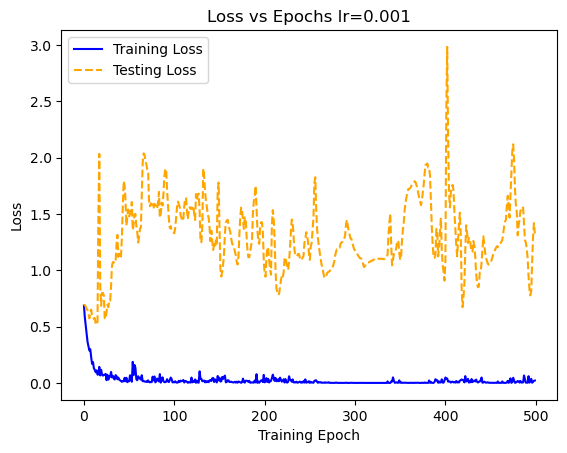

In [125]:
# visualize the train and test loss
# create array for x values for plotting train
epochs_array = list(range(epochs))
title = f'Loss vs Epochs lr={lr}'
# Graph the test and train data
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
plt.plot(epochs_array, train_loss, color='b', label="Training Loss")
plt.plot(epochs_array, loss_array, '--', color='orange', label='Testing Loss')
axs.set_ylabel('Loss')
axs.set_xlabel('Training Epoch')
axs.set_title(f"{title}")
axs.legend()
fig.savefig(f'{title}.png')



In [126]:
# Save model
save_path = 'gnn_model.pth'
torch.save(model.state_dict(), save_path)